In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
from typing import List
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


%matplotlib inline

# The MNIST Dataset

The MNIST dataset is a large database of handwritten digits that is used as a benchmark and an introduction to machine learning and image processing systems. We like MNIST because the dataset is very clean and this allows us to focus on the actual network training and evaluation. Remember: a clean dataset is a luxury in the ML world! So let’s enjoy and celebrate MNIST’s cleanliness while we can :)

## The objective

Given a dataset of 60,000 handwritten digit images (represented by 28x28 pixels, each containing a value 0 - 255 with its grayscale value), train a system to classify each image with it's respective label (the digit that is displayed).

## The dataset

The dataset is composed of a training and testing dataset, but for simplicity we are only going to be using the training set. Below we can download the train dataset

In [2]:
%%bash

rm -Rf train-images-idx3-ubyte.gz
rm -Rf train-labels-idx1-ubyte.gz 
wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

# Reading the labels

There are 10 possible handwritten digits: (0-9), therefore every label must be a number from 0 to 9. The file that we downloaded, `train-labels-idx1-ubyte.gz`, encodes labels as following:

### TRAINING SET LABEL FILE (train-labels-idx1-ubyte):

```
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
0004     32 bit integer  60000            number of items 
0008     unsigned byte   ??               label 
0009     unsigned byte   ??               label 
........ 
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.
```

It looks like the first 8 bytes (or the first 2 32-bit integers) can be skipped because they contain metadata of the file that is usually useful to lower-level programming languages.
To parse the file, we can perform the following operations:

- Open the file using the gzip library, so that we can decompress the file
- Read the entire byte array into memory
- Skip the first 8 bytes
- Iterate over every byte, and cast that byte to integer

NOTE: If this file was not from a trusted source, a lot more checking would need to be done. For the purpose of this blog post, I'm going to assume the file is valid in it's integrity.

In [3]:
with gzip.open('train-labels-idx1-ubyte.gz') as train_labels:
    data_from_train_file = train_labels.read()

# Skip the first 8 bytes, we know exactly how many labels there are
label_data = data_from_train_file[8:]
assert len(label_data) == 60000

# Convert every byte to an integer. This will be a number between 0 and 9
labels = [int(label_byte) for label_byte in label_data]
assert min(labels) == 0 and max(labels) == 9
assert len(labels) == 60000


## Reading the images



```
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000803(2051) magic number 
0004     32 bit integer  60000            number of images 
0008     32 bit integer  28               number of rows 
0012     32 bit integer  28               number of columns 
0016     unsigned byte   ??               pixel 
0017     unsigned byte   ??               pixel 
........ 
xxxx     unsigned byte   ??               pixel
```

Reading images is slightly different than reading labels. The first 16 bytes contain metadata that we already know. We can skip those bytes and directly proceed to reading the images. Every image is represented as a 28*28 unsigned byte array. All we have to do is read one image at a time and save it into an array.

In [4]:
SIZE_OF_ONE_IMAGE = 28 ** 2
images = []

# Iterate over the train file, and read one image at a time
with gzip.open('train-images-idx3-ubyte.gz') as train_images:
    train_images.read(4 * 4)
    ctr = 0
    for _ in range(60000):
        image = train_images.read(size=SIZE_OF_ONE_IMAGE)
        assert len(image) == SIZE_OF_ONE_IMAGE
        
        # Convert to numpy
        image_np = np.frombuffer(image, dtype='uint8') / 255
        images.append(image_np)

images = np.array(images)
images.shape

(60000, 784)

Our `images` list now contains 60,000 images. Each image is represented as a byte vector of `SIZE_OF_ONE_IMAGE` 
Let's try to plot an image using the `matplotlib` library:

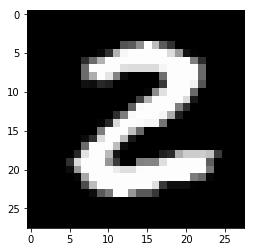

In [5]:
def plot_image(pixels: np.array):
    plt.imshow(pixels.reshape((28, 28)), cmap='gray')
    plt.show()

plot_image(images[25])

# Encoding image labels using one-hot encoding

We are going to use [One-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our target labels into a vector. 

In [6]:
labels_np = np.array(labels).reshape((-1, 1))

encoder = OneHotEncoder(categories='auto')
labels_np_onehot = encoder.fit_transform(labels_np).toarray()

labels_np_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

We have successfully created input and output vectors that will be fed into the input and output layers of our neural network. The input vector at index `i` will correspond to the output vector at index `i`

In [7]:
labels_np_onehot[999]


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

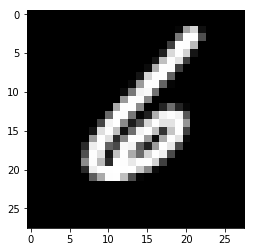

In [8]:
plot_image(images[999])

In the example above, we can see that the image at index `999` clearly represents a 6. It's associated output vector contains 10 digits (since there are 10 available labels) and the digit at index 6 is set to 1, indicating that it's the correct label. 

# Building train and test split

In order to check that our ANN has correctly been trained, we take a percentage of the train dataset (our 60,000 images) and set it aside for testing purposes.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_np_onehot)

In [10]:
y_train.shape

(45000, 10)

In [23]:
y_test.shape

(15000, 10)

As you can see, our dataset of 60,000 images was split into one dataset of 45,000 images, and the other of 15,000 images.

## Training a Neural Network using Keras

In [11]:
model = keras.Sequential()
model.add(keras.layers.Dense(input_shape=(SIZE_OF_ONE_IMAGE,), units=128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [12]:
X_train.shape

(45000, 784)

In [13]:
model.fit(X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
45000/45000 [==============================] - 7s 157us/step - loss: 1.3326 - acc: 0.6789
Epoch 2/20
45000/45000 [==============================] - 7s 147us/step - loss: 0.6368 - acc: 0.8510
Epoch 3/20
45000/45000 [==============================] - 7s 145us/step - loss: 0.4947 - acc: 0.8730
Epoch 4/20
45000/45000 [==============================] - 7s 150us/step - loss: 0.4335 - acc: 0.8844
Epoch 5/20
45000/45000 [==============================] - 7s 155us/step - loss: 0.3977 - acc: 0.8910
Epoch 6/20
45000/45000 [==============================] - 7s 155us/step - loss: 0.3733 - acc: 0.8968
Epoch 7/20
45000/45000 [==============================] - 7s 158us/step - loss: 0.3551 - acc: 0.9018
Epoch 8/20
45000/45000 [==============================] - 8s 176us/step - loss: 0.3407 - acc: 0.9048
Epoch 9/20
45000/45000 [==============================] - 8s 172us/step - loss: 0.3288 - acc: 0.9076
Epoch 10/20
45000/45000 [==============================] - 7s 159us/step - loss: 0.3185 - a

In [14]:
model.evaluate(X_test, y_test)

15000/15000 [==============================] - 1s 99us/step


[0.2552573989232381, 0.9267333333015442]

# Inspecting the results

Congratulations! you just trained a neural network to predict handwritten digits with 92.6% accuracy! Let's test out the network with one of the pictures we have in our testset

Let's take a random image, in this case the image at index `1010`. We take the predicted label (in this case, the value is a 6 because the 7th index is set to 1)

In [15]:
y_test[1010]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Let's plot the image of the corresponding image

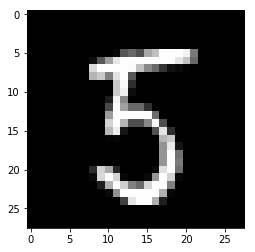

In [16]:
plot_image(X_test[1010])

### Understanding the output of a softmax activation layer

Now, let's run this nuber through the neural network and we can see what our predicted output looks like!

In [17]:
predicted_results = model.predict(X_test[1010].reshape((1, -1)))

The output of a softmax layer is a probability distribution for every output. In our case, there are 10 possible outputs (digits 0-9). Of course, every one of our images is expected to only match one specific output (in other words, all of our images only contain one distinct digit).

Because this is a probability distribution, the sum of the predicted results is 1.0

In [18]:
predicted_results.sum()

1.0000002

### Reading the output of a softmax activation layer for our digit

As you can see below, the 7th index is really close to 1 (0.9) which means that there is a 90% probability that this digit is a 6... which it is! congrats!

In [19]:
predicted_results

array([[1.5168362e-03, 6.8481922e-06, 5.6828873e-04, 1.0812344e-02,
        4.1737610e-05, 9.6712565e-01, 1.0736840e-04, 2.5940110e-06,
        1.9747535e-02, 7.0929571e-05]], dtype=float32)

# Viewing the confusion matrix

In [20]:

predicted_outputs = np.argmax(model.predict(X_test), axis=1)
expected_outputs = np.argmax(y_test, axis=1)

predicted_confusion_matrix = confusion_matrix(expected_outputs, predicted_outputs)

In [21]:
predicted_confusion_matrix

array([[1435,    0,    2,    3,    6,    8,    6,    1,   11,    2],
       [   0, 1711,   10,    7,    2,    6,    2,    1,   10,    2],
       [   6,   11, 1352,   19,   27,    3,   21,   14,   26,   10],
       [   6,   12,   28, 1406,    1,   50,   10,   19,   38,   18],
       [   1,    8,    6,    3, 1339,    0,   18,    4,   10,   54],
       [  21,    5,   13,   43,   12, 1206,   24,    2,   16,   13],
       [  10,    7,   14,    0,   18,   14, 1405,    0,    9,    0],
       [   5,   11,   21,    5,   14,    1,    2, 1432,    5,   37],
       [   6,   19,   15,   29,    2,   30,   12,    1, 1261,   22],
       [   8,    8,    8,   18,   40,    9,    1,   34,   13, 1354]])

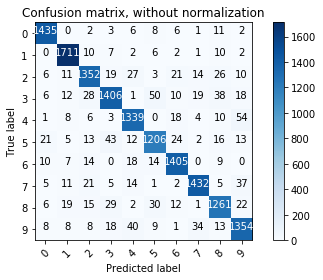

In [22]:


# Source code: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
class_names = [str(idx) for idx in range(10)]
cnf_matrix = confusion_matrix(expected_outputs, predicted_outputs)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()